In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package punkt to
[nltk_data]     /home/matthewbolding/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/matthewbolding/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/matthewbolding/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matthewbolding/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/matthewbolding/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
model_path = "longformer_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Loaded Longformer model from {model_path}")


In [2]:
df = pd.read_csv("data/Gungor_2018_VictorianAuthorAttribution_data-train.csv", encoding="ISO-8859-1")
df['author_label'] = df['author'].astype('category').cat.codes
label_map = dict(enumerate(df['author'].astype('category').cat.categories))

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['author_label'].tolist(),
    test_size=0.1,
    stratify=df['author_label'],
    random_state=42
)


In [3]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            name = lemma.name().replace('_', ' ')
            if name.lower() != word.lower():
                synonyms.add(name)
    return list(synonyms)

def synonym_substitution(text, rate=0.05):
    words = word_tokenize(text)
    new_words = words.copy()
    
    candidates = [i for i, w in enumerate(words) if w.isalpha() and w.lower() not in stop_words]
    num_changes = max(1, int(len(candidates) * rate))
    indices_to_replace = random.sample(candidates, min(num_changes, len(candidates)))

    for idx in indices_to_replace:
        word = words[idx]
        synonyms = get_synonyms(word)
        if synonyms:
            new_words[idx] = random.choice(synonyms)

    return ' '.join(new_words)


In [4]:
def antonym_substitution(text, rate=0.05):
    words = word_tokenize(text)
    new_words = words.copy()
    candidates = [i for i, w in enumerate(words) if w.isalpha() and w.lower() not in stop_words]
    num_changes = max(1, int(len(candidates) * rate))
    indices_to_replace = random.sample(candidates, min(num_changes, len(candidates)))

    for idx in indices_to_replace:
        word = words[idx]
        antonyms = [a.name().replace('_', ' ')
                    for syn in wordnet.synsets(word)
                    for lemma in syn.lemmas()
                    for a in lemma.antonyms()]
        if antonyms:
            new_words[idx] = random.choice(antonyms)

    return ' '.join(new_words)


In [5]:
def insert_noise_words(text, rate=0.05):
    filler_words = [
        "indeed", "clearly", "furthermore", "basically", "evidently", "thus",
        "notably", "importantly", "meanwhile", "nevertheless", "insofar",
        "consequently", "hence", "nonetheless", "accordingly", "albeit",
        "regardless", "incidentally", "undoubtedly", "specifically"
    ]
    words = word_tokenize(text)
    num_insertions = max(1, int(len(words) * rate))
    positions = sorted(random.sample(range(len(words)), num_insertions))

    for idx in reversed(positions):
        words.insert(idx, random.choice(filler_words))

    return ' '.join(words)


In [ ]:
substitution_rates = [rate / 100 for rate in range(0, 55, 5)]

attack_results = {
    "synonym": [],
    "antonym": [],
    "insertion": []
}
attack_confidences = {
    "synonym": [],
    "antonym": [],
    "insertion": []
}

attack_funcs = {
    "synonym": synonym_substitution,
    "antonym": antonym_substitution,
    "insertion": insert_noise_words
}

for attack_name in attack_funcs:
    print(f"\nEvaluating attack: {attack_name}")
    for rate in substitution_rates:
        correct = 0
        confidences = []

        for i in tqdm(range(len(val_texts))):
            text = val_texts[i]
            label = val_labels[i]
            adv_text = attack_funcs[attack_name](text, rate) if rate > 0 else text

            inputs = tokenizer(
                adv_text,
                truncation=True,
                padding="max_length",
                max_length=2048,
                return_tensors="pt"
            ).to(device)

            global_attention_mask = torch.zeros_like(inputs['input_ids'])
            global_attention_mask[:, 0] = 1

            outputs = model(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                global_attention_mask=global_attention_mask
            )

            probs = F.softmax(outputs.logits, dim=-1)
            pred = torch.argmax(probs, dim=1).item()
            conf = probs[0, pred].item()

            confidences.append(conf)
            if pred == label:
                correct += 1

        acc = correct / len(val_texts)
        attack_results[attack_name].append(1 - acc)  # attack success rate
        attack_confidences[attack_name].append(np.mean(confidences))


In [ ]:
import pickle

with open("attack_metrics.pkl", "wb") as f:
    pickle.dump({
        "substitution_rates": substitution_rates,
        "attack_results": attack_results,
        "attack_confidences": attack_confidences
    }, f)

print("Saved attack metrics to attack_metrics.pkl")


In [6]:
import pickle

with open("attack_metrics.pkl", "rb") as f:
    data = pickle.load(f)

substitution_rates = data["substitution_rates"]
attack_results = data["attack_results"]
attack_confidences = data["attack_confidences"]

print(substitution_rates)
print(attack_results)
print(attack_confidences)

print("Loaded saved attack metrics")


[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
{'synonym': [0.03334575260804773, 0.03222801788375562, 0.03576751117734722, 0.04415052160953803, 0.04880774962742174, 0.0577496274217586, 0.07507451564828616, 0.09277198211624438, 0.11661698956780919, 0.1369225037257824, 0.17734724292101345], 'antonym': [0.03334575260804773, 0.03353204172876301, 0.03315946348733234, 0.03539493293591656, 0.03502235469448589, 0.03539493293591656, 0.03595380029806261, 0.036326378539493276, 0.03874813710879288, 0.04135618479880776, 0.04116989567809237], 'insertion': [0.03334575260804773, 0.2947093889716841, 0.5132265275707899, 0.6220193740685545, 0.6978390461997019, 0.7583830104321907, 0.8019746646795827, 0.8384873323397913, 0.8638226527570789, 0.88301043219076, 0.892511177347243]}
{'synonym': [np.float64(0.9923834324205064), np.float64(0.9914502868048525), np.float64(0.9917445765855415), np.float64(0.9886714389878041), np.float64(0.9873731041191098), np.float64(0.9860491287907038), np.float64(0.

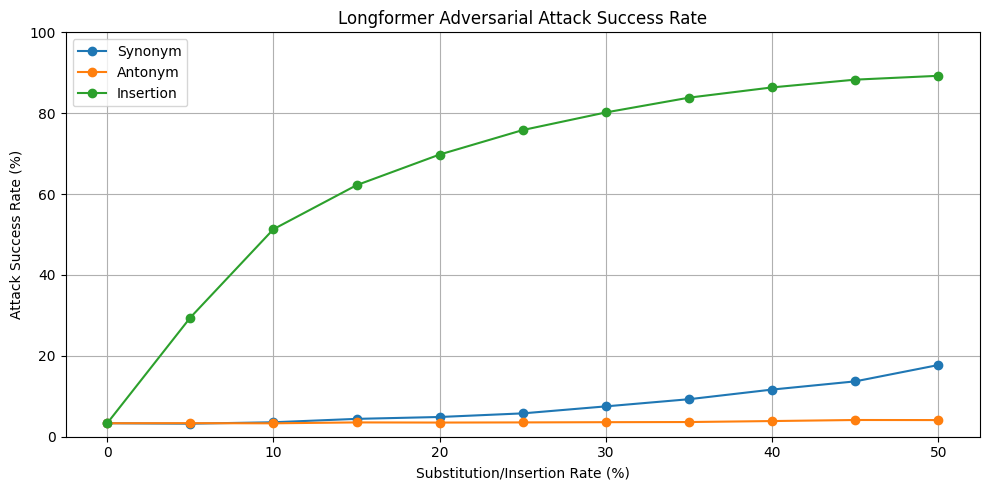

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
rates = [r * 100 for r in substitution_rates]

for name, values in attack_results.items():
    plt.plot(rates, [v * 100 for v in values], label=name.title(), marker='o')

plt.xlabel("Substitution/Insertion Rate (%)")
plt.ylabel("Attack Success Rate (%)")
plt.title("Longformer Adversarial Attack Success Rate")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


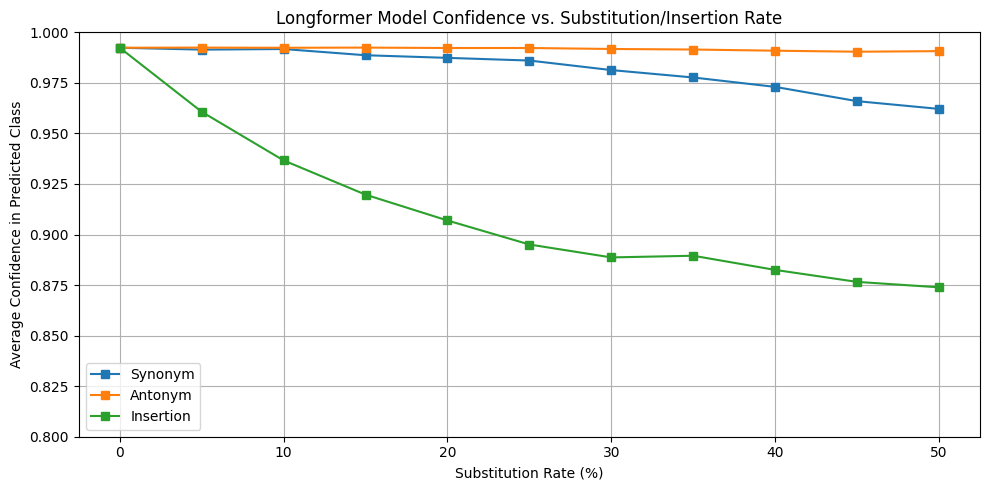

In [8]:
plt.figure(figsize=(10, 5))

for name, values in attack_confidences.items():
    plt.plot(rates, values, label=name.title(), marker='s')

plt.xlabel("Substitution Rate (%)")
plt.ylabel("Average Confidence in Predicted Class")
plt.title("Longformer Model Confidence vs. Substitution/Insertion Rate")
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
num_examples = 10  # number of validation examples to inspect
perturbation_rate = 0.3  # use 30% substitution/insertion rate

for i in range(num_examples):
    original = val_texts[i]

    synonym_attacked = synonym_substitution(original, rate=perturbation_rate)
    antonym_attacked = antonym_substitution(original, rate=perturbation_rate)
    insertion_attacked = insert_noise_words(original, rate=perturbation_rate)

    print(f"\n🔎 Example {i+1}")
    print("=" * 80)
    print("Original:")
    print(original[:500] + "...")
    
    print("\nWith Synonym Substitution:")
    print(synonym_attacked[:500] + "...")
    
    print("\nWith Antonym Substitution:")
    print(antonym_attacked[:500] + "...")
    
    print("\nWith Word Insertion:")
    print(insertion_attacked[:500] + "...")
    print("=" * 80)



🔎 Example 1
Original:
of the â whom she had known when and his wife believed in each other â and answered i will send it i think it will do her good but remember we must never tell her the truth guessed that his own watch was in the colonel s possession and thought that the return watches of the night of the lip with a soothing note from mrs would merely create a small trouble for a few minutes mrs knew better she knew that any poison dropped would find good holding ground in the heart of the colonel s wife the packe...

With Synonym Substitution:
of the â whom she had known when and his wife believed in each other â and answered i will send it i think it will do her good but remember we must never William Tell her the Sojourner Truth guessed that his own watch was in the colonel s possession and thought that the return watches of the night of the rim with a soothing note from mrs would merely create a little inconvenience oneself for a few minutes mrs knew better she knew that any po